In [1]:
import os
from glob import glob
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
basedir = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

In [28]:
def normalize_position_and_rotation(samples: list[torch.tensor]) -> torch.tensor:
    # position and rotation are encoded [x, y, z, w, x, y, z] and samples is a list of such vectors
    positions = torch.stack([s[:3] for s in samples])
    print(f"Original positions: {positions}")
    rotations = torch.stack([s[3:] for s in samples])

    # normalize position of each frame to the frame before it, so that the first frame is always [0, 0, 0]
    new_pos = [positions[0] - positions[0]]
    for i in range(1, positions.shape[0]):
        new_pos.append(positions[i] - positions[i-1])

    new_pos = torch.stack(new_pos)
    print(f"New positions: {new_pos}")
    
    # normalize rotation to the frame before it
    new_rot = [R.from_quat(rotations[0]).inv() * R.from_quat(rotations[0])]
    for i in range(1, rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[i-1]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return torch.concatenate((positions, new_rot), axis=1)

In [30]:
def reset_position_and_rotation_to_first_node(nodes, edge_index, y):
  print(f"Original y: {y}")
  y = normalize_position_and_rotation(y)
  print(f"Normalized y: {y}")
  return nodes, edge_index, y

In [36]:
dataset = MultipleSequenceGraphDataset(
    basedir, train_sequences, transform=reset_position_and_rotation_to_first_node, graph_length=7
)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model = PoseGNN().to(device)
criterion = PoseLoss()

In [35]:
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

loss_history = []
for epoch in range(1, 151):
    model.train()
    epoch_loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        break
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})
       
    loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
    print(f"Epoch {epoch} loss: {sum(epoch_loss_history) / len(epoch_loss_history)}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/model_B_{epoch}.pth")

torch.save(model.state_dict(), f"models/model_B_final.pth")

Epoch 1:   0%|          | 0/20184 [00:00<?, ?it/s]

Original y: tensor([[-1.8565e+00, -2.3709e+00,  8.1973e+01,  6.5350e-04, -1.8124e-02,
         -1.5746e-03,  9.9983e-01],
        [-1.8958e+00, -2.3931e+00,  8.3032e+01,  1.5279e-03, -1.8399e-02,
         -1.1786e-03,  9.9983e-01],
        [-1.9367e+00, -2.4177e+00,  8.4088e+01,  1.7873e-03, -1.8651e-02,
         -1.2564e-03,  9.9982e-01],
        [-1.9771e+00, -2.4439e+00,  8.5139e+01,  2.2288e-03, -1.8853e-02,
         -7.8195e-04,  9.9982e-01],
        [-2.0179e+00, -2.4664e+00,  8.6185e+01,  2.6505e-03, -1.9082e-02,
         -2.1455e-04,  9.9981e-01],
        [-2.0602e+00, -2.4901e+00,  8.7238e+01,  1.6954e-03, -1.9350e-02,
         -2.3707e-04,  9.9981e-01],
        [-2.1038e+00, -2.5132e+00,  8.8286e+01,  8.6676e-04, -1.9483e-02,
         -3.8836e-04,  9.9981e-01],
        [-2.1465e+00, -2.5363e+00,  8.9329e+01,  8.1048e-04, -1.9237e-02,
         -5.3821e-04,  9.9981e-01],
        [-2.1878e+00, -2.5591e+00,  9.0368e+01,  1.3094e-03, -1.8617e-02,
         -6.9472e-04,  9.9983e-01]

ZeroDivisionError: division by zero

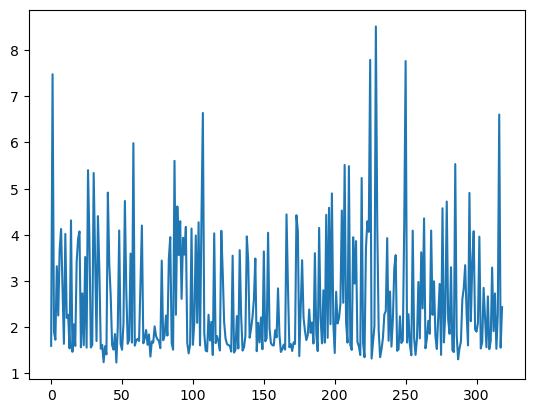

In [9]:
# plot loss
plt.plot(loss_history)
plt.show()